In [17]:
# import standard libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools

from sklearn.datasets import load_iris
from sklearn import tree, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_fscore_support,f1_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from shutil import copyfile
from imblearn.under_sampling import ClusterCentroids

In [20]:
# load train data
train_data = pd.read_csv('../data/MoreManipulatedData_bucket_last_col.csv',usecols=lambda x: 'PLAYER_URL' not in x)

# different classes
train_data.BUCKET.unique()

# convert string values to numerical data
def convert(data):
    number = preprocessing.LabelEncoder()
    data['POS'] = number.fit_transform(data.POS)
    data['LEAGUE'] = number.fit_transform(data.LEAGUE)
    data['FIRST_JUNIOR_YEAR'] = number.fit_transform(data.FIRST_JUNIOR_YEAR)
    data['DOB'] = number.fit_transform(data.DOB)
    data['NATIONALITY'] = number.fit_transform(data.NATIONALITY)
    data['SHOOTS'] = number.fit_transform(data.SHOOTS)
    data=data.fillna(-999)
    return data

# convert string values in data to numerical classes
train_data = convert(train_data)

# Separating the data and the labels
X = np.asarray(train_data[train_data.columns[:-1]])
y = np.asarray(train_data.BUCKET)

In [21]:
cc = ClusterCentroids(random_state=0, sampling_strategy='majority')
X_resampled, y_resampled = cc.fit_resample(X, y)

# Separating the data and the labels


# Splitting the data into the train and the test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

train_index, test_index = next(sss.split(X_resampled, y_resampled))
X_train, X_test = X_resampled[train_index], X_resampled[test_index]
y_train, y_test = y_resampled[train_index], y_resampled[test_index]

print('Training data: \n',X)
print('\n')
print('Training labels: \n',y_train)

Training data: 
 [[103143      3     87 ...    180     84      2]
 [106210      1     73 ...    193     95      0]
 [106207      2     21 ...    183     86      0]
 ...
 [249307      1    130 ...    188     98      3]
 [485033      3     59 ...    175     68      2]
 [410552      2      1 ...    183     82      2]]


Training labels: 
 [' 601+    ' ' 1-200   ' ' 1-200   ' ... ' 201-600 ' ' 201-600 '
 ' 601+    ']


In [42]:
# K Nearest Neighbors Classifier (has to be able to deal with floats)
MLP = MLPClassifier(hidden_layer_sizes=(10,),solver= 'adam', learning_rate_init = 0.00001, max_iter=10000,random_state=0,tol=1e-5)

# learning_rate_init=0.0001,learning_rate='invscaling',activation='logistic'
# fit the classifier using the training data
MLP = MLP.fit(X_train, y_train)

# Predict the test class labels using the trained KNN classifier 
y_pred = MLP.predict(X_test)

# print accuracy of the classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    1-200          0.65      0.58      0.61       408
    201-600        0.34      0.26      0.30       156
    601+           0.39      0.43      0.41       127
           0       0.61      0.93      0.74       127

    accuracy                           0.55       818
   macro avg       0.50      0.55      0.51       818
weighted avg       0.55      0.55      0.54       818



Confusion matrix, without normalization
[[237  52  59  60]
 [ 78  41  26  11]
 [ 40  28  55   4]
 [  9   0   0 118]]


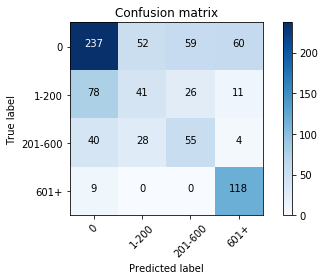

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, axes = plt.subplots(1, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm,['0','1-200','201-600','601+'])

In [9]:
print(MLP.n_layers_)
print(precision_recall_fscore_support(y_test, y_pred)[2][3])
print(f1_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred,average='micro'))
print(f1_score(y_test, y_pred,average='weighted'))

3
0.9489288914229861
0.3951114950012613
0.8874626865671642
0.8721191515809892


In [25]:
from joblib import dump, load
dump(MLP, '../finished_models/mlp_adam_lr0_00001.joblib') 

['../finished_models/mlp_adam_lr0_00001.joblib']

In [26]:
# This is a champ: '../finished_models/mlp_hid1000_layer3_try2.joblib'
MLP2 = load('../finished_models/mlp_adam_lr0_00001.joblib') 
# Predict the test class labels using the trained KNN classifier 
y_pred = MLP2.predict(X_test)

# print accuracy of the classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    1-200          0.64      0.67      0.66       408
    201-600        0.25      0.26      0.26       156
    601+           0.37      0.32      0.34       127
           0       0.74      0.68      0.71       127

    accuracy                           0.54       818
   macro avg       0.50      0.48      0.49       818
weighted avg       0.54      0.54      0.54       818

